# Test Various CNN architectures on the layer identification task


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from Classifier_models import CNN1D_Small, CNN1D_Large, train_model, identify_device

## Import Data 

In [2]:
device = identify_device()

Using device: mps


In [3]:
# Load the dataset with weights_only=False
data = torch.load("Synthetic_data_60k.pt", weights_only=False)

# Extract components
synthetic_data = data["synthetic_data"]
material_params = data["material_params"]
num_layers = data["num_layers"]

print("Dataset loaded successfully!")
print(f"Number of samples: {len(synthetic_data)}")
print(f"Shape of synthetic_data: {synthetic_data.shape}")
print(f"Shape of num_layers: {num_layers.shape}")
print(f"Example number of layers: {num_layers[:10]}")

num_classes = int(max(num_layers)) # class labels start at 1 not 0.

Dataset loaded successfully!
Number of samples: 60000
Shape of synthetic_data: torch.Size([60000, 1024])
Shape of num_layers: torch.Size([60000])
Example number of layers: tensor([1, 1, 3, 1, 2, 2, 1, 2, 2, 1])


In [4]:
# Adjust labels for training (CrossEntropyLoss expects 0-based class labels)
num_layers_adjusted = num_layers - 1  # Convert labels from 1–5 → 0–4

# Ensure shapes are as expected
print("synthetic_data shape (after unsqueeze):", synthetic_data.unsqueeze(1).shape)
print("num_layers (original):", num_layers[:10])
print("num_layers_adjusted (for training):", num_layers_adjusted[:10])


synthetic_data shape (after unsqueeze): torch.Size([60000, 1, 1024])
num_layers (original): tensor([1, 1, 3, 1, 2, 2, 1, 2, 2, 1])
num_layers_adjusted (for training): tensor([0, 0, 2, 0, 1, 1, 0, 1, 1, 0])


In [5]:
num_classes = int(num_layers_adjusted.max().item()) + 1  # e.g., 5 if max label is 4
batch_size = 1024

# Unsqueeze to add channel dimension for Conv1D input: [B, 1, 1024]
synthetic_data = synthetic_data.unsqueeze(1)  # [100, 1, 1024]

# Create TensorDataset with adjusted labels
train_dataset = TensorDataset(synthetic_data, num_layers_adjusted)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

## Train and Test Small CNN

In [6]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Small(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Epoch 1/10: 100%|██████████| 59/59 [00:04<00:00, 11.81batch/s, loss=1.1]


Epoch [1/10], Loss: 1.0980


Epoch 2/10: 100%|██████████| 59/59 [00:04<00:00, 13.01batch/s, loss=1.02]


Epoch [2/10], Loss: 1.0192


Epoch 3/10: 100%|██████████| 59/59 [00:04<00:00, 12.55batch/s, loss=0.921]


Epoch [3/10], Loss: 0.9209


Epoch 4/10: 100%|██████████| 59/59 [00:04<00:00, 13.19batch/s, loss=0.909]


Epoch [4/10], Loss: 0.9092


Epoch 5/10: 100%|██████████| 59/59 [00:04<00:00, 12.66batch/s, loss=0.901]


Epoch [5/10], Loss: 0.9011


Epoch 6/10: 100%|██████████| 59/59 [00:04<00:00, 13.13batch/s, loss=0.895]


Epoch [6/10], Loss: 0.8953


Epoch 7/10: 100%|██████████| 59/59 [00:04<00:00, 12.27batch/s, loss=0.886]


Epoch [7/10], Loss: 0.8856


Epoch 8/10: 100%|██████████| 59/59 [00:04<00:00, 13.16batch/s, loss=0.875]


Epoch [8/10], Loss: 0.8754


Epoch 9/10: 100%|██████████| 59/59 [00:04<00:00, 13.19batch/s, loss=0.863]


Epoch [9/10], Loss: 0.8628


Epoch 10/10: 100%|██████████| 59/59 [00:04<00:00, 12.66batch/s, loss=0.848]


Epoch [10/10], Loss: 0.8482


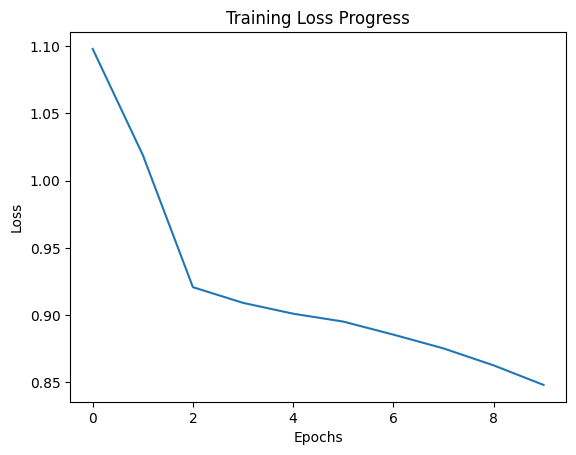

In [7]:
# Train the model
loss_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=10)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()


Validation Accuracy: 0.5920


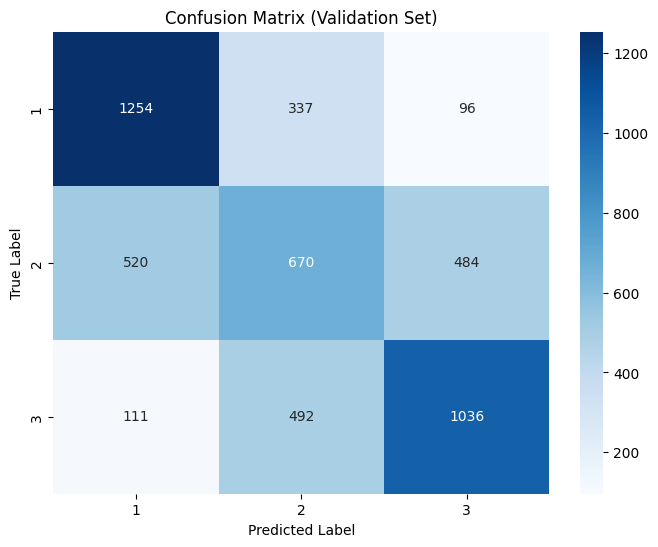

In [8]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\Unseen dataset Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

## Train and test Larger CNN

In [9]:
# Initialize the model, criterion, and optimizer
model = CNN1D_Large(input_channels=1, num_classes=num_classes).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Optional: Print shapes and label stats for sanity check
print("Data shape:", synthetic_data.shape)
print("Label range:", num_layers_adjusted.min().item(), "to", num_layers_adjusted.max().item())
print("Number of classes:", num_classes)

Data shape: torch.Size([60000, 1, 1024])
Label range: 0 to 2
Number of classes: 3


Epoch 1/10: 100%|██████████| 59/59 [00:21<00:00,  2.81batch/s, loss=0.58] 


Epoch [1/10], Loss: 0.5799


Epoch 2/10: 100%|██████████| 59/59 [00:18<00:00,  3.11batch/s, loss=0.361]


Epoch [2/10], Loss: 0.3613


Epoch 3/10: 100%|██████████| 59/59 [00:18<00:00,  3.18batch/s, loss=0.314]


Epoch [3/10], Loss: 0.3139


Epoch 4/10: 100%|██████████| 59/59 [00:18<00:00,  3.26batch/s, loss=0.284]


Epoch [4/10], Loss: 0.2839


Epoch 5/10: 100%|██████████| 59/59 [00:17<00:00,  3.30batch/s, loss=0.253]


Epoch [5/10], Loss: 0.2525


Epoch 6/10: 100%|██████████| 59/59 [00:17<00:00,  3.29batch/s, loss=0.241]


Epoch [6/10], Loss: 0.2415


Epoch 7/10: 100%|██████████| 59/59 [00:18<00:00,  3.21batch/s, loss=0.237]


Epoch [7/10], Loss: 0.2367


Epoch 8/10: 100%|██████████| 59/59 [00:18<00:00,  3.16batch/s, loss=0.226]


Epoch [8/10], Loss: 0.2258


Epoch 9/10: 100%|██████████| 59/59 [00:18<00:00,  3.17batch/s, loss=0.221]


Epoch [9/10], Loss: 0.2213


Epoch 10/10: 100%|██████████| 59/59 [00:18<00:00,  3.15batch/s, loss=0.208]


Epoch [10/10], Loss: 0.2081


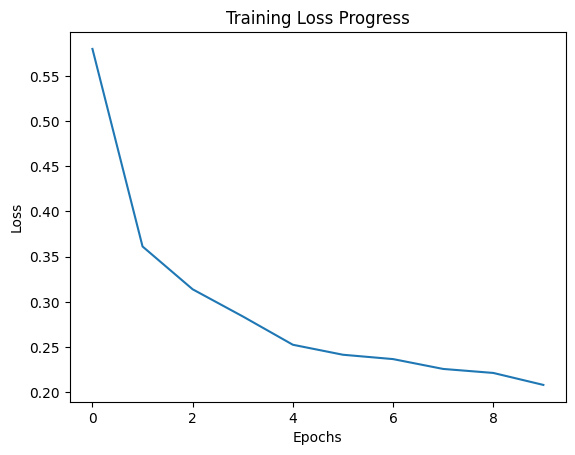

In [10]:
# Train the model
loss_values = train_model(model, train_loader, criterion, optimizer, device=device, num_epochs=10)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Progress')
plt.show()


Validation Accuracy: 0.3376


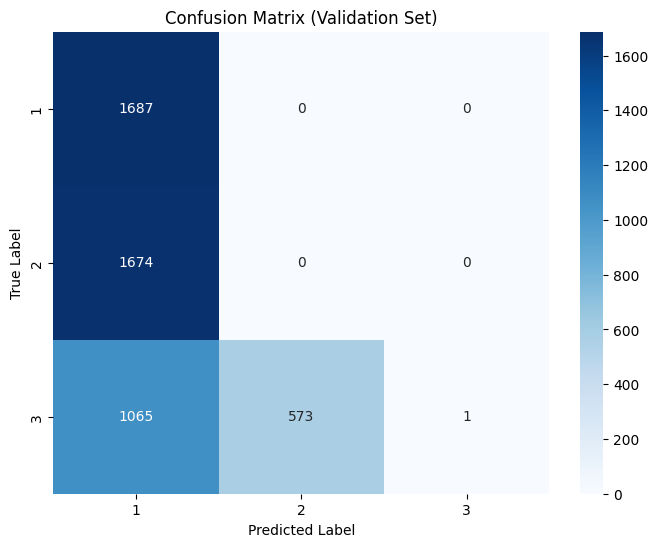

In [11]:
# Load the validation dataset
val_data = torch.load("Validation.pt", weights_only=False)

val_synthetic_data = val_data["synthetic_data"]         # shape: [N, 1024]
val_num_layers = val_data["num_layers"]                 # shape: [N]
val_num_layers_adjusted = val_num_layers - 1            # match training label indexing

# Unsqueeze to match model input shape
val_synthetic_data = val_synthetic_data.unsqueeze(1)    # shape: [N, 1, 1024]

# Create DataLoader for validation
val_dataset = TensorDataset(val_synthetic_data, val_num_layers_adjusted)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())   # move back to CPU before numpy
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix and accuracy
cm = confusion_matrix(all_labels, all_preds)
acc = accuracy_score(all_labels, all_preds)

print(f"\nValidation Accuracy: {acc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"{i+1}" for i in range(cm.shape[0])],
            yticklabels=[f"{i+1}" for i in range(cm.shape[0])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation Set)")
plt.show()